In [1]:
# TODO notch filter is not done
import os
import mne
import numpy as np
import pandas as pd
from scipy.signal import welch
from fooof import FOOOF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30),
    'gamma': (30, 50)
}

def load_eeg_data(base_dir, filename):
    file_path = os.path.join(base_dir, filename)
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    # Load a standard 10-20 montage
    montage = mne.channels.make_standard_montage("standard_1020")

    # Get only the channels that exist in the montage
    valid_channels = [ch for ch in raw.ch_names if ch in montage.ch_names]
    raw.pick_channels(valid_channels)

    # Apply montage
    raw.set_montage(montage)

    raw.set_eeg_reference(ref_channels='average')
    raw.pick_types(eeg=True)
    print(" ############################## DONE - Data loaded. ############################## ")
    return raw

def get_info(raw):
    print(" ############################## DONE - Channel names:", raw.ch_names, "############################## ")
    print(" ############################## DONE - Annotations:", raw.annotations, "############################## ")

def preprocessing(raw):
    # Convert annotations to events
    events, _ = mne.events_from_annotations(raw)

    # Find timestamps for sw-2 and sw-3
    # TODO try to do if not number then go to the sw-4
    sw2_time = None
    sw3_time = None
    for annot in raw.annotations:
        if annot['description'] == 'sw_2':
            sw2_time = annot['onset']
        elif annot['description'] == 'sw_3':
            sw3_time = annot['onset']

    if sw2_time is None or sw3_time is None:
        raise ValueError("Could not find sw_2 or sw_3 annotations")
    
    print(f" sw_2 at {sw2_time:.2f}s, sw_3 at {sw3_time:.2f}s")

    raw_resting = raw.copy().crop(tmin=sw2_time, tmax=sw3_time)
    raw_resting.filter(0.5, 50, fir_design='firwin')
    #raw_resting.notch_filter(freqs=50)
    raw_resting.plot(n_channels=8, scalings='auto', title='Eyes-Closed Resting EEG', show=True)
    print(" ############################## DONE - Preprocessing done - cropping and filtering. ############################## ")
    return raw_resting

def turn_into_epochs_and_annotate(raw_resting):
    # Segmentation into epochs of 2 seconds
    epochs = mne.make_fixed_length_epochs(raw_resting, duration=2.0, preload=True)
    stds = np.std(epochs.get_data(), axis=(1, 2))
    threshold = np.mean(stds) + 2 * np.std(stds)
    bad_epochs = np.where(stds > threshold)[0]

    # # Annotate detected bad segments
    for epoch_idx in bad_epochs:
        onset = epochs.events[epoch_idx, 0] / raw_resting.info['sfreq']
        raw_resting.annotations.append(onset, 2, "BAD")
        
    print(" ############################## DONE - Turned into epochs and annotations done. ############################## ")
    return raw_resting, epochs

def compute_psd(raw_resting,epochs, fmin=1, fmax=40):
    # Make sure data is 3D: (epochs, channels, time)
    data = epochs.get_data()
    sfreq = raw_resting.info['sfreq']

    # Reshape into 2D: (n_epochs * n_channels, n_times)
    n_epochs, n_channels, n_times = data.shape
    psd_all = []
    for ch in range(n_channels):
        psd_ch = []
        for ep in range(n_epochs):
            freqs, psd = welch(data[ep, ch, :], fs=sfreq, nperseg=n_times)
            psd_ch.append(psd)
        psd_ch = np.mean(psd_ch, axis=0)  # mean across epochs for that channel
        psd_all.append(psd_ch)

    psd_all = np.array(psd_all)  # shape: (n_channels, n_freqs)
    mean_psd = np.mean(psd_all, axis=0)  # mean across channels
    # === Calculate average power in each frequency band ===
    band_powers = {}
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.mean(mean_psd[idx])  # or np.trapz(mean_psd[idx], freqs[idx]) for total power
        band_powers[band] = band_power

    # Print results
    print("Band Power (µV²/Hz):")
    for band, power in band_powers.items():
        print(f"  {band.capitalize():<6}: {power:.6e}")
    
    raw_resting.compute_psd(fmax=60).plot(picks="data", exclude="bads", amplitude=False)

    print("############################## DONE - Computing PSD ############################## ")
    return freqs, psd_all, psd_all, mean_psd, band_powers

def apply_fooof(freqs, mean_psd, subject_id="subject"):
    fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, aperiodic_mode='fixed')
    freq_mask = (freqs >= 1) & (freqs <= 40)
    fm.fit(freqs[freq_mask], mean_psd[freq_mask])

    # 1. Fit FOOOF to Averaged PSD (1–40 Hz)
    fm.report()
    
    # 2. Extract Metrics
    # Aperiodic Components:
    offset = fm.aperiodic_params_[0]   # baseline "height" of 1/f
    exponent = fm.aperiodic_params_[1] # slope of 1/f curve

    # Periodic Peaks — Center Frequency (CF), Power, Bandwidth per Band
    bands_focus = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (13, 30)
    }

    band_fooof_features = {}
    for band, (low, high) in bands_focus.items():
        peaks = [p for p in fm.peak_params_ if low <= p[0] <= high]
        if peaks:
            best_peak = max(peaks, key=lambda x: x[1])  # by amplitude
            band_fooof_features[f'{band}_cf'] = best_peak[0]
            band_fooof_features[f'{band}_pw'] = best_peak[1]
            band_fooof_features[f'{band}_bw'] = best_peak[2]
        else:
            band_fooof_features[f'{band}_cf'] = None
            band_fooof_features[f'{band}_pw'] = None
            band_fooof_features[f'{band}_bw'] = None

    fooof_summary = {
    'aperiodic_offset': offset,
    'aperiodic_exponent': exponent,
    **band_fooof_features
}

    df_fooof = pd.DataFrame([fooof_summary], index=[subject_id])
    print("############################## DONE - Computing FOOOF ############################## ")
    # df_fooof.to_csv("FELIX02_fooof_parameters.csv")
    return df_fooof

# def cluster_features(features, n_clusters=2):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(features)
#     score = silhouette_score(features, labels)
#     return labels, score

def process_subject(base_dir, filename, subject_id="subject"):
    raw = load_eeg_data(base_dir, filename)
    get_info(raw)
    raw_resting = preprocessing(raw)
    raw_resting, epochs = turn_into_epochs_and_annotate(raw_resting)
    freqs, psd_all, psd_all, mean_psd, band_powers = compute_psd(raw_resting, epochs)
    df_fooof = apply_fooof(freqs, mean_psd, subject_id)
    print("FOOOF Analysis:", df_fooof.T)
    # features = np.array([res.aperiodic_params_ for res in fooof_results if res.has_model])
    # if len(features) > 1:
    #     labels, score = cluster_features(features)
    #     print(f'Silhouette Score: {score:.2f}')
    #     return labels, features
    # else:
    #     print("Not enough valid FOOOF models for clustering.")
    #     return None, None


/var/folders/fy/wgbms_gd5cdfzmkw53vtsh740000gn/T/ipykernel_26381/2110564297.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/FELIX Database/Baseline analysis/FELIX02/Explore_CA45_20Nov2023_125449_ExG.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 683499  =      0.000 ...  1366.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
 ############################## DONE - Data loaded. ############################## 
 ############################## DONE - Channel names: ['Fp1', 'Fp2', 'F1', 'F2', 'P1', 'P2', 'O1', 'O2'] ############################## 
 ############################## DONE - Annotations: <Annotations | 4 segments: sw_1 (1), sw_2 (1), sw_3 (1), sw_4 (1)> ###########################

/var/folders/fy/wgbms_gd5cdfzmkw53vtsh740000gn/T/ipykernel_26381/2110564297.py:70: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  stds = np.std(epochs.get_data(), axis=(1, 2))
/var/folders/fy/wgbms_gd5cdfzmkw53vtsh740000gn/T/ipykernel_26381/2110564297.py:84: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


############################## DONE - Computing PSD ############################## 
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.8486, 0.9271                                         
                                                                                                  
                         

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


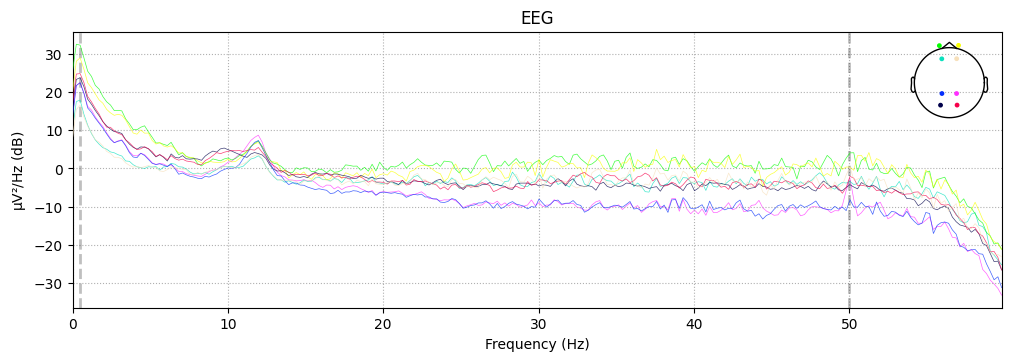

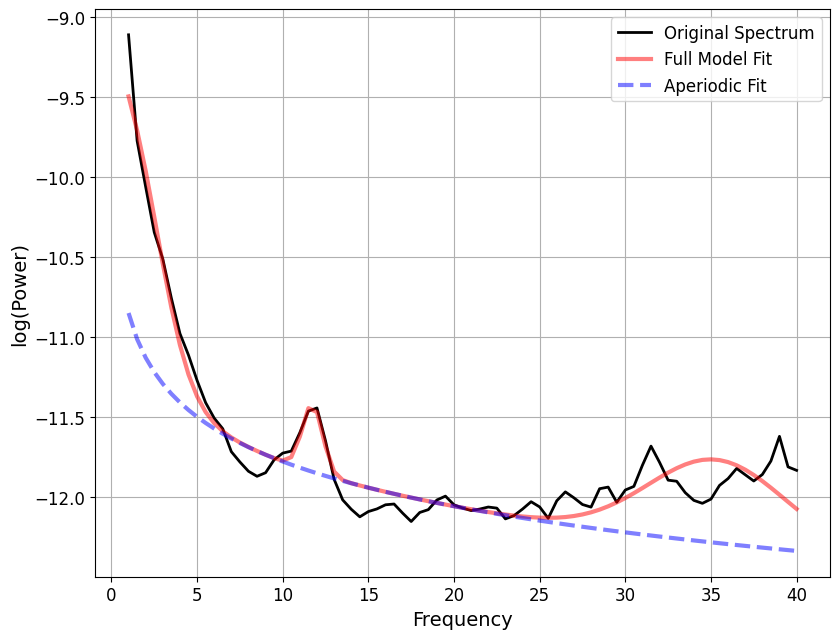

Channels marked as bad:
none


In [2]:
# Example usage:
base_dir = "Baseline analysis/FELIX02"
filename = "Explore_CA45_20Nov2023_125449_ExG.bdf"
subject_id="FELIX02"
process_subject(base_dir, filename)